In [221]:
# Import libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read in csv for all universities
df = pd.read_csv('all_posts.csv')
df.shape

(2996, 7)

Social media tends to have a lot of memes/non-sensical discussion. For this project it would be valuable to filter out these types of posts and focus on posts that are more likely to have criticisms about the university.

In [170]:
# Want to see post flairs, and subsequently filter for non-shitposts
df['flair'].unique()

array(['Transfers', 'Discussion', 'Humour', 'Serious', 'News', 'Other',
       'Rant', 'Health', 'Clubs/Sports', 'Social', 'Event', 'Courses',
       'Waterloo #173', 'Academics', 'Advice', 'Confirmed', 'Meta', nan,
       'Shitpost', 'Lost & Found', 'Question', 'Politics', 'Life Advice',
       'Admissions', 'Finances', 'Programs', 'ACORN/Quercus/Outlook',
       'Free Speech', 'Waterloo #201–250', 'UTM/UTSC',
       "I'm in High School", 'Jobs', 'Photography & Art',
       'Pho(ur seasons)tography & Art', '@ SFU (Exception)', 'Megathread',
       'Congrats, you made it!', 'Photography &amp; Art',
       'Humour - Satire', 'SFU = Studying For UBC', 'Prose', '🍁',
       '100% super duper confirmed by the r/byssey', '🔥🔥🔥',
       'Ghost-type Humour', 'Unverified', 'Lost Dog', '🎉🎉🎉',
       'Read Comments Section for full context', 'Missing Person', 'F',
       'Spicy', 'HQ Post', 'Spicy Meme', 'We did it, reddit!',
       'HQ shitpost', 'Certified Dank', 'shitpost', 'Political',
       

In [172]:
# Most popular flairs
df['flair'].value_counts()[:10]

flair
Humour               961
Discussion           223
Other                159
Photography & Art    116
shitpost              73
News                  49
Academics             28
Advice                22
Courses               22
HQ Post               21
Name: count, dtype: int64

In [174]:
# Filter for popular/relevant flairs
df = df[df['flair'].isin(['Humour', 'Discussion', 'Other', 'News', 'Academics', 'Advice', 'Courses', 'HQ Post'])]
df.shape

(1485, 7)

# Cleaning Data

In [222]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Init stopwords
stop_words = set(stopwords.words("english"))

def clean_text(df):
    '''
    This function does 3 things

    1. Combines text from title, description and comments
    2. Normalizes university names
    3. Tokenizes and lemmatizes text and removes stopwords + reddit specific words

    '''
    remove_words = ['removed', 'deleted', '[ removed by reddit ]', '[deleted]']
    # custom_stopwords = {'student', 'course', 'people', 'get', 'like', 'time', 'year', 'would'}
    # Combine text from title, description and comments
    def combine_text(text): 

        if isinstance(text, list):
            return ' '.join([word for word in text if isinstance(word, str) and word.lower() not in remove_words])
        elif isinstance(text, str): 
            # Filter out posts removed by reddit
            if re.search(r"\[?\s*removed by reddit.*?\]?", text, flags=re.IGNORECASE):
                return ''
            return text
        return ''

    
    
    # Normalize university names
    def normalize_university(text):
        # Regex to normalize uni names
        text = re.sub(r'u\sof\st', 'uoft', text)
        text = re.sub(r'university of toronto', 'uoft', text)
        text = re.sub(r'university of british columbia', 'ubc', text)
        return text

    # Tokenize + lematize + remove stopwords
    def tokenize_and_lemmatize(text): 

        # Tokenize
        tokens = word_tokenize(text)

        # Filter for strings
        words = [word for word in tokens if word.isalpha()]

        # Remove stopwords
        words = [word for word in words if word not in stop_words]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]
    
    # Combine text
    df['combined_text'] = (df['title'].apply(combine_text).fillna('') + ' ' +
                       df['description'].apply(combine_text).fillna('') + ' ' +
                       df['comments'].apply(combine_text))

    # Lower + removing trailing charsa
    df['combined_text'] = df['combined_text'].str.lower().str.strip()
    
    # Normalize university names
    df['combined_text'] = df['combined_text'].apply(normalize_university)

    # Tokenize + lemmatize
    df['lemmatized_tokens'] = df['combined_text'].apply(tokenize_and_lemmatize)

    # Return cleaned df
    return df

df = clean_text(df)

df.head()

,date_created,title,description,comments,upvotes,flair,university,combined_text,lemmatized_tokens
0,2025-02-12 18:36:14,To the student who got caught using AI on their exam at U of T Law,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...,"['[deleted]', 'It’s crazy that there’s people mad at YOU for venting.', 'Gaining access to your ...",2942,Transfers,UofT,to the student who got caught using ai on their exam at uoft law thanks a lot you dumb f*ck. due...,"[student, got, caught, using, ai, exam, uoft, law, thanks, lot, dumb, f, ck, due, idiocy, dumbas..."
1,2024-11-08 03:24:09,[ Removed by Reddit ],[ Removed by Reddit on account of violating the [content policy](/help/contentpolicy). ],"['Ik this man, he’s getting cooked. Maybe uoft won’t do anything but it’s over for him and his s...",2939,Discussion,UofT,"['ik this man, he’s getting cooked. maybe uoft won’t do anything but it’s over for him and his s...","[man, getting, cooked, maybe, uoft, anything, social, life, esp, w, apparently, deleted, twitter..."
2,2020-11-13 19:48:06,I want a ps5,NaN,"['i LOVE how low effort this looks', 'pain', 'loool u made my day..', 'Those boys and scalpers ...",2749,Humour,UofT,"i want a ps5 ['i love how low effort this looks', 'pain', 'loool u made my day..', 'those boys...","[want, love, low, effort, look, u, made, day, boy, scalper, really, took, thing, quick, shopper,..."
3,2016-12-14 00:38:33,If this thread gets over 300 upvotes in the next 24h I will change the sub to r/idealcatering un...,"srsly don't fuck this up for me, we're already working on the css don't want this shit to go to ...","['[deleted]', '[deleted]', ""Found this in /r/all/rising, I'll give my updoot."", ""/r/uwaterloo's ...",2485,Serious,UofT,if this thread gets over 300 upvotes in the next 24h i will change the sub to r/idealcatering un...,"[thread, get, upvotes, next, change, sub, exam, srsly, fuck, already, working, cs, want, shit, g..."
4,2025-05-14 00:11:02,University of Toronto Faculty Association votes to divest from Israel,NaN,"['Big W, honestly im surprised', 'W faculty', 'Honestly amazing to hear!', 'Proud of my alma mat...",2163,News,UofT,"uoft faculty association votes to divest from israel ['big w, honestly im surprised', 'w facult...","[uoft, faculty, association, vote, divest, israel, w, honestly, im, surprised, w, faculty, amazi..."


## Investigating top k words

In [223]:
from collections import Counter

def get_topk_words(df, k):
    '''
    Takes a df and returns top k words from tokens
    '''
    all_tokens = [token for row in df['lemmatized_tokens'] for token in row]

    # Count frequencies
    token_counts = Counter(all_tokens)

    # Get top K words
    top_k = token_counts.most_common(k)

    return top_k

# Get top 10 most common words across all posts
print(f'---All Posts---\n{get_topk_words(df, 10)}')

# Get top 10 most common words across flairs
for flair in df['flair'].unique():
    print(f'---{flair}---\n{get_topk_words(df[df['flair'] == flair], 10)}')


---All Posts---
[('people', 15312), ('like', 14454), ('student', 13110), ('get', 11587), ('year', 9617), ('one', 9602), ('would', 9429), ('time', 8748), ('think', 8472), ('know', 7732)]
---Transfers---
[('ai', 60), ('college', 52), ('lawyer', 34), ('use', 32), ('law', 30), ('school', 28), ('university', 28), ('student', 26), ('using', 21), ('people', 21)]
---Discussion---
[('people', 3817), ('like', 3058), ('student', 2560), ('get', 2262), ('would', 1921), ('one', 1875), ('year', 1851), ('think', 1815), ('time', 1560), ('know', 1559)]
---Humour---
[('like', 2250), ('get', 1882), ('year', 1841), ('people', 1606), ('one', 1567), ('student', 1558), ('course', 1456), ('time', 1429), ('would', 1160), ('class', 1133)]
---Serious---
[('http', 21), ('deleted', 16), ('get', 12), ('goose', 11), ('meme', 10), ('u', 10), ('post', 9), ('hour', 9), ('uoft', 9), ('upvotes', 8)]
---News---
[('people', 699), ('student', 545), ('like', 378), ('get', 358), ('would', 343), ('one', 328), ('think', 313), ('

It seems all posts feature words that are probably common throughout each flair.

Mutual Information (MI). If we treat our flair as a rough topic label, we can use MI to tell us information that is shared in the non-linear relationships between tokens and flairs.

### Preparing df for MI calculations

In [224]:
# 500 most common words across all universities
top_500 = get_topk_words(df, 500)

# 500 most common words for each university
uoft_df = df[df['university'] == 'UofT']
ubc_df = df[df['university'] == 'UBC']
mcgill_df = df[df['university'] == 'McGill']

uoft_500 = get_topk_words(uoft_df, 500)
ubc_500 = get_topk_words(ubc_df, 500)
mcgill_500 = get_topk_words(mcgill_df, 500)

# Convert words to bool columns for MI
def create_mi_df(df):

    # Get top k words
    top_500 = get_topk_words(df, 500)

    # Save flair column
    mi_df = df[['flair']].copy()

    # Convert words to bool columns
    binary_columns = []
    
    for word, _ in top_500:
        binary_series = df['lemmatized_tokens'].apply(lambda tokens: int(word in tokens))
        binary_series.name = word
        binary_columns.append(binary_series)

    # Concatenate all columns at once
    binary_df = pd.concat(binary_columns, axis=1)

    # Combine with the flair column
    mi_df = pd.concat([mi_df, binary_df], axis=1)

    return mi_df

# Get MI ready df for all + each university
all_mi = create_mi_df(df)
uoft_mi = create_mi_df(uoft_df)
ubc_mi = create_mi_df(ubc_df)
mcgill_mi = create_mi_df(mcgill_df)


### Making getMI function

In [225]:
from sklearn.metrics import mutual_info_score

def getMI(df, label_column = 'flair'):

    # Get list of topk words from MI df
    topk = df.select_dtypes(include = np.number).columns

    # Get label column names
    unique_labels = df[label_column].unique()

    all_scores = []

    for flair in unique_labels:
        label = (df[label_column] == flair).astype(int)

        # Get MI for topk words in flair
        for word in topk:
            score = mutual_info_score(label, df[word])
            all_scores.append({'word': word, 'mi': score, 'flair': flair})

    return pd.DataFrame(all_scores).sort_values(by='mi', ascending=False)

In [226]:
all_mi_scores = getMI(all_mi)
uoft_mi_scores = getMI(uoft_mi)
ubc_mi_scores = getMI(ubc_mi)
mcgill_mi_scores = getMI(mcgill_mi)

In [227]:
all_mi_scores.head(10)

,word,mi,flair
1040,mcgill,0.068635,Humour
1099,hope,0.026098,Humour
647,else,0.022138,Discussion
547,lot,0.022100,Discussion
2543,uoft,0.021509,Other
1152,health,0.020930,Humour
1082,around,0.020727,Humour
1075,campus,0.020607,Humour
1455,montreal,0.020460,Humour
507,time,0.020138,Discussion


Noticing that words with highest MI seem to be just the most common words... Will see what normalizing for word frequency does.

# Sentiment Analysis

In [181]:
from nltk.sentiment import SentimentIntensityAnalyzer

def evalsentences(sentences, universities, to_df = False, columns = []):
    sid = SentimentIntensityAnalyzer()
    pdlist = []

    if to_df:
        # Maintain index from original df
        for i, sentence in (sentences.items() if isinstance(sentences, pd.Series) else enumerate(sentences)):
            ss = sid.polarity_scores(sentence)
            row = [sentence, ss['compound']]
            if universities is not None:
                uni_val = universities.loc[i] if isinstance(universities, pd.Series) else universities[i]
                row.append(uni_val)
            pdlist.append((i, row))
        
        # Build into df
        df = pd.DataFrame([row for _, row in pdlist],
                          index=[idx for idx, _ in pdlist],
                          columns=columns)
        return df
    
    else:
        for sentrence in sentences:
            print('\n' + sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k], end = ''))
            print()

Text(0.5, 1.0, 'Distribution of VADER sentiment scores across posts')

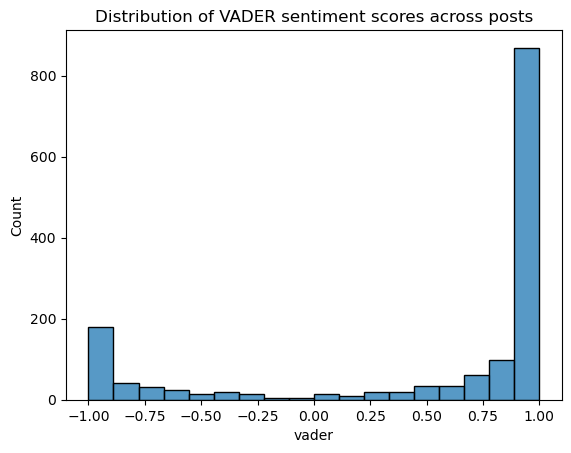

In [154]:
comments = df['combined_text']
universities = df['university']
vader_df = evalsentences(comments, universities, to_df = True, columns = ['comments', 'vader', 'university_name'])

# See distribution of sentiment across posts
sns.histplot(vader_df['vader'])
plt.title('Distribution of VADER sentiment scores across posts')

In [155]:
# Set option to show longer comments
pd.set_option('display.max_colwidth', 100)

# Add flair back in
vader_df['flair'] = df['flair']

# See what percent of comments are rated negative from VADER by flair
vader_df['is_neg'] = vader_df['vader'] < 0

percent_neg = (vader_df.groupby('flair')['is_neg']
               .mean()
               .round(2) 
               ).sort_values(ascending = False)

percent_neg

flair
News          0.45
Humour        0.23
Discussion    0.22
Academics     0.18
Other         0.18
Advice        0.14
HQ Post       0.14
Courses       0.05
Name: is_neg, dtype: float64

## PMI

In [156]:
import math
import numpy as np

def calcpmi(df, topk_words, gt_sentiment, label_column, smoothing = 1):

    # Number of observations
    n = len(df)
    label_mask = df[label_column] == gt_sentiment

    pmi_scores = []

    # Add smoothing to avoid log(0)
    px = label_mask.sum() + smoothing

    # Math for pmi
    for word, _ in topk_words:

        word_mask = df[word] == True

        py = word_mask.sum() + smoothing

        pxy = (label_mask & word_mask).sum() + smoothing

        pmi = np.log((pxy * n) / (px*py))

        pmi_scores.append((word, pmi))
    
    return pd.DataFrame(pmi_scores, columns = ['word', 'pmi']).set_index('word')
 

In [157]:
# Create pmi df
pmi_df = pd.concat([mi_df, vader_df[['is_neg', 'university_name']]], axis = 1)

# Get top pmi for words and negative sentiment across all posts
calcpmi(pmi_df, top_500, 'negative', 'is_neg').sort_values(by = 'pmi', ascending= False).head(10)

,pmi
word,
university,7.303170
israel,4.412798
pharmacy,4.084294
roommate,3.837434
indigenous,3.806662
wage,3.614291
vaccine,3.589598
protest,3.589598
china,3.295837


### Investigating words associated with negative sentiment by flair at each uni

UofT

In [186]:
uoft_pmi = pd.concat([uoft_mi, vader_df[['is_neg', 'university_name']]], axis = 1)

for flair in uoft_pmi['flair'].unique():
    print(f'------{flair}-------')
    print(calcpmi(uoft_pmi[uoft_pmi['flair'] == flair], uoft_500, 'negative', 'is_neg').sort_values(by = 'pmi', ascending= False).head(10))

------Discussion-------
                  pmi
word                 
roommate     3.850148
genocide     3.444682
hamas        2.933857
palestinian  2.751535
cheating     2.597385
israel       2.597385
pharmacy     2.597385
vaccine      2.597385
schedule     2.463853
letter       2.463853
------Humour-------
                  pmi
word                 
hamas        6.236370
israel       6.236370
palestinian  6.236370
genocide     4.850075
pharmacy     4.626932
protest      4.626932
roommate     4.290459
vaccine      4.156928
police       4.039145
war          3.933784
------News-------
                 pmi
word                
assignment  3.555348
english     3.555348
pharmacy    3.555348
humanity    2.862201
cheat       2.862201
cheating    2.862201
letter      2.456736
skill       2.456736
c           2.456736
luck        2.456736
------Other-------
                  pmi
word                 
hamas        4.375757
israel       4.375757
vaccine      4.375757
palestinian  4.375757
pharmac

C:\Users\toirt\AppData\Local\Temp\ipykernel_29624\3500840323.py:24: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((pxy * n) / (px*py))


In [191]:
ubc_pmi = pd.concat([ubc_mi, vader_df[['is_neg', 'university_name']]], axis = 1)

for flair in ubc_pmi['flair'].unique():
    print(f'------{flair}-------')
    print(calcpmi(ubc_pmi[ubc_pmi['flair'] == flair], ubc_500, 'negative', 'is_neg').sort_values(by = 'pmi', ascending= False).head(10))

------Discussion-------
                pmi
word               
tipping    3.761200
protest    3.068053
cpen       2.913902
rain       2.662588
server     2.662588
proctorio  2.557227
driver     2.557227
wolf       2.461917
china      2.461917
wage       2.374906
------Humour-------
                 pmi
word                
tipping     5.416100
wolf        5.010635
indigenous  4.722953
restaurant  4.317488
racism      4.317488
police      4.317488
protest     4.317488
china       4.163337
rain        4.163337
wage        4.029806
------News-------
               pmi
word              
wolf      2.639057
driver    2.639057
culture   2.639057
cpen      2.639057
rain      2.639057
computer  2.639057
tipping   2.639057
server    2.639057
sleep     2.639057
library   2.639057
------nan-------
           pmi
word          
people    -inf
teaching  -inf
worse     -inf
exactly   -inf
test      -inf
joke      -inf
lmao      -inf
check     -inf
im        -inf
community -inf


C:\Users\toirt\AppData\Local\Temp\ipykernel_29624\3500840323.py:24: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((pxy * n) / (px*py))


In [192]:
mcgill_pmi = pd.concat([mcgill_mi, vader_df[['is_neg', 'university_name']]], axis = 1)

for flair in mcgill_pmi['flair'].unique():
    print(f'------{flair}-------')
    print(calcpmi(ubc_pmi[ubc_pmi['flair'] == flair], ubc_500, 'negative', 'is_neg').sort_values(by = 'pmi', ascending= False).head(10))

------HQ Post-------
           pmi
word          
people    -inf
teaching  -inf
worse     -inf
exactly   -inf
test      -inf
joke      -inf
lmao      -inf
check     -inf
im        -inf
community -inf
------nan-------
           pmi
word          
people    -inf
teaching  -inf
worse     -inf
exactly   -inf
test      -inf
joke      -inf
lmao      -inf
check     -inf
im        -inf
community -inf


C:\Users\toirt\AppData\Local\Temp\ipykernel_29624\3500840323.py:24: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((pxy * n) / (px*py))
C:\Users\toirt\AppData\Local\Temp\ipykernel_29624\3500840323.py:24: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((pxy * n) / (px*py))


### Looking at comments level

In [229]:
comment_rows = []

for _, row in df.iterrows():
    for comment in eval(row['comments']):
        comment_rows.append({
            'comments': comment,
            'title': row['title'],
            'date_created': row['date_created'],
            'university_name': row['university'],
            'flair': row['flair'],
            'description': row['description']
        })

comments_df = pd.DataFrame(comment_rows)
comments_df.head()

,comments,title,date_created,university_name,flair,description
0,[deleted],To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...
1,It’s crazy that there’s people mad at YOU for venting.,To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...
2,Gaining access to your hard drives feels like a huge violation of privacy? I’m surprised that’s ...,To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...
3,?,To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...
4,[removed],To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...


In [230]:
def clean_comments(text): 
    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)            # Remove newlines
    text = re.sub(r'http\S+', '', text)        # Remove links
    text = re.sub(r'[^a-z\s]', '', text)       # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()
    return text

comments_df['comments'] = comments_df['comments'].apply(clean_comments)
comments_df['comments'] = comments_df['comments'].str.strip()
comments_df = comments_df[~comments_df['comments'].isin(['deleted', 'removed', ''])]
comments_df = comments_df.reset_index(drop=True)
comments_df.head()

,comments,title,date_created,university_name,flair,description
0,its crazy that theres people mad at you for venting,To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...
1,gaining access to your hard drives feels like a huge violation of privacy im surprised thats eve...,To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...
2,what canadian says college,To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...
3,sighs sounds exhausting best of luck,To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...
4,oof i only use ai for helping me understand concepts and actually backing up what it says with s...,To the student who got caught using AI on their exam at U of T Law,2025-02-12 18:36:14,UofT,Transfers,Thanks a lot you dumb f*ck. Due to your idiocy and dumbassery my college (not in Ontario) is now...


In [233]:
def tokenize_and_lemmatize(text): 
        # Tokenize
        tokens = word_tokenize(text)

        # Filter for strings
        words = [word for word in tokens if word.isalpha()]

        # Remove stopwords
        words = [word for word in words if word not in stop_words]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]

comments_df['lemmatized_tokens'] = comments_df['comments'].apply(tokenize_and_lemmatize)

In [234]:
comments_df['lemmatized_tokens']

0                                                                        [crazy, there, people, mad, venting]
1         [gaining, access, hard, drive, feel, like, huge, violation, privacy, im, surprised, thats, even,...
2                                                                                    [canadian, say, college]
3                                                                       [sigh, sound, exhausting, best, luck]
4         [oof, use, ai, helping, understand, concept, actually, backing, say, source, idk, many, ppl, use...
                                                         ...                                                 
110420    [new, course, catalogue, awful, lacking, ability, see, course, subject, unreal, thanks, good, wo...
110421                                     [think, lot, people, agree, old, system, worked, better, honestly]
110422                                                                [incoming, student, life, saver, thank]
110423    

In [238]:
complaint_keywords = [
    'hate', 'bad', 'terrible', 'worst', 'awful', 'complain', 'issue', 
    'problem', 'suck', 'annoy', 'disappoint', 'frustrate', 'dumb', 
    'incompetent', 'bureaucracy', 'useless', 'slow', 'broken'
]

def is_complaint(tokens):
    return any(token in complaint_keywords for token in tokens)

comments_df['is_complaint'] = comments_df['lemmatized_tokens'].apply(is_complaint)


In [243]:
complaint_keywords = ['course', 'class', 'test', 'prof', 'professor', 'exam']

def is_complaint(tokens):
    return any(token in complaint_keywords for token in tokens)

comments_df['is_complaint'] = comments_df['lemmatized_tokens'].apply(is_complaint)

In [251]:
comments_vader = evalsentences(comments_df['comments'], comments_df['university_name'], to_df = True, columns = ['comments', 'vader', 'university_name'])

In [252]:
comments_df['vader'] = comments_vader['vader']

In [253]:
comments_df['joined_text'] = comments_df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

In [254]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(comments_df['joined_text'])


In [ ]:
comments_df

Index(['comments', 'title', 'date_created', 'university_name', 'flair',
       'description', 'lemmatized_tokens', 'is_complaint', 'vader',
       'joined_text'],
      dtype='object')

In [262]:
comments_df.sample(n=1000, random_state=42).to_csv('labelling.csv')

In [255]:
X

<110425x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1301198 stored elements in Compressed Sparse Row format>

In [212]:
uoft_comments = comments_df[comments_df['university_name'] == 'UofT'].reset_index(drop=True)
ubc_comments = comments_df[comments_df['university_name'] == 'UBC'].reset_index(drop=True)
mcgill_comments = comments_df[comments_df['university_name'] == 'McGill'].reset_index(drop=True)